In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Load data

In [2]:
mat = loadmat('snp452-data.mat')
columns = list()
cls = list()
for i in range(452):
    code = mat['stock'][0,i][0,0][0].tolist()[0]
    clz = mat['stock'][0,i][0,0][2].tolist()[0]
    columns.append(code.replace('"', '')) 
    cls.append(clz.replace('"', ''))

snp = pd.DataFrame(mat['X'],columns = columns)
classes = pd.DataFrame([cls],columns = columns,index=['class'])
class_uni = classes.loc['class'].unique()
class_uni

array(['Industrials', 'Financials', 'Health Care',
       'Consumer Discretionary', 'Information Technology', 'Utilities',
       'Materials', 'Consumer Staples', 'Telecommunications Services',
       'Energy'], dtype=object)

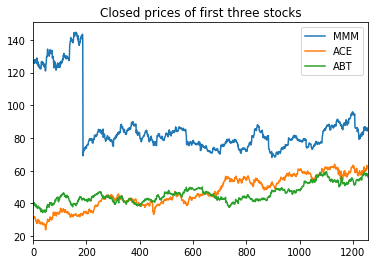

In [3]:
snp.MMM.plot()
snp.ACE.plot()
snp.ABT.plot()
plt.title('Closed prices of first three stocks')
plt.legend(['MMM','ACE','ABT'])

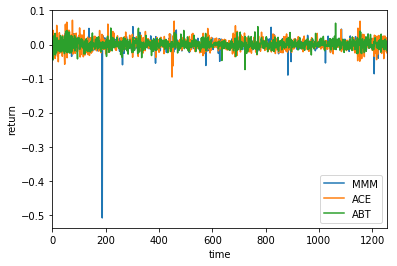

In [4]:
snp.MMM.pct_change().plot()
snp.ACE.pct_change().plot()
snp.ABT.pct_change().plot()
#plt.title('Returns of three stocks')
plt.legend(['MMM','ACE','ABT'])
plt.xlabel('time')
plt.ylabel('return')

In [5]:
snp = snp.pct_change().drop(index = 0)
for i in range(1257):
    for j in range(452):
        if abs(snp.values[i][j])>0.2:
            if i<1255:
                snp.replace(snp.values[i][j], 0.5*(snp.values[i-1][j]+snp.values[i+1][j]), inplace=True)
            else:
                snp.replace(snp.values[i][j], snp.values[i-1][j], inplace=True)

Exclude the sharpness (giant events affecting the stock price)

Divide the stocks into 10 catogries of data sets.

In [6]:
ind = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Industrials']).T
fi = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Financials']).T
hc = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Health Care']).T
cd = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Consumer Discretionary']).T
it = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Information Technology']).T
ut = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Utilities']).T
ma = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Materials']).T
cs = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Consumer Staples']).T
ts = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Telecommunications Services']).T
en = pd.DataFrame(snp,columns = [x for x in snp.columns if classes.loc['class'][x]=='Energy']).T

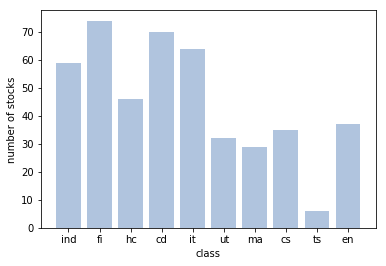

In [7]:
cat = [ind,fi,hc,cd,it,ut,ma,cs,ts,en]
num = list()
abb_new = ['ind','fi','hc','cd','it','ut','ma','cs','ts','en']
for cats in cat:
    num.append(cats.shape[0])
plt.bar(range(10),num,color = 'lightsteelblue')
plt.xticks(range(10), abb_new)
plt.xlabel('class')
plt.ylabel('number of stocks')

In [8]:
cat_new = [ind,fi,hc,cd,it,ut,ma,cs,en]
abb_old = abb_new.copy()
abb_new.remove('ts')

PCA analysis

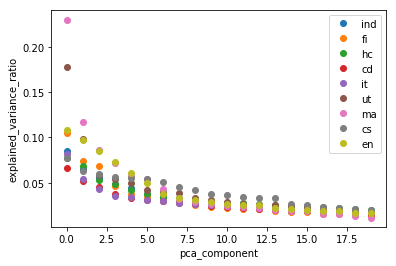

In [9]:
from sklearn.decomposition import PCA
for cats in cat_new:
    pca = PCA(n_components=20, svd_solver='arpack')
    pca.fit(cats)
    plt.plot(pca.explained_variance_ratio_, "o", linewidth=2)
plt.legend(abb_new)
plt.xlabel('pca_component')
plt.ylabel('explained_variance_ratio')

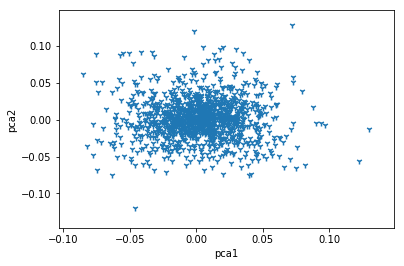

In [18]:
pca = PCA(n_components=20, svd_solver='arpack')
pca.fit(ma)
pca1 = pca.components_[0,:]
pca2 = pca.components_[1,:]
plt.scatter(pca1,pca2,marker = "1")
plt.xlabel('pca1')
plt.ylabel('pca2')

In [16]:
pca.explained_variance_ratio_.sum()

0.931190671179637

In [20]:
def train(df):
    X = df.T.iloc[:,0:-1]
    Y = df.T.iloc[:,-1]
    my_pipeline = make_pipeline(SimpleImputer(), RandomForestRegressor())
    scores = cross_val_score(my_pipeline, X, Y, scoring='neg_mean_absolute_error')
    return -1 * scores.mean()

In [21]:
score_1 = list()
for cats in cat:
    score_1.append(train(cats))
for i in range(len(abb_old)):
    print("The MAE of '%s' is : %f"%(classes.loc['class'].unique()[i],score_1[i]))

The MAE of 'Industrials' is : 0.007926
The MAE of 'Financials' is : 0.006530
The MAE of 'Health Care' is : 0.009951
The MAE of 'Consumer Discretionary' is : 0.009281
The MAE of 'Information Technology' is : 0.013691
The MAE of 'Utilities' is : 0.006169
The MAE of 'Materials' is : 0.007799
The MAE of 'Consumer Staples' is : 0.012532
The MAE of 'Telecommunications Services' is : 0.007756
The MAE of 'Energy' is : 0.014147


In [22]:
def dnn(df):
    X = df.T.iloc[:,0:-1]
    Y = df.T.iloc[:,-1]
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, random_state = 0)
    model = Sequential()
    model.add(Dense(input_dim = X.shape[1],output_dim = 100, activation='relu'))
    for i in range(2):
        model.add(Dense(output_dim = 100,activation='relu'))
    model.add(Dense(output_dim = 1))
    model.compile(loss = 'mae',optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_X,train_Y,batch_size = 100, epochs = 20)
    score = model.evaluate(test_X,test_Y,batch_size=1000)[1]
    return score

In [23]:
score_2 = list()
for cats in cat:
    score_2.append(dnn(cats))
for i in range(len(abb_old)):
    print("The MAE of '%s' is : %f"%(classes.loc['class'].unique()[i],score_2[i]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
942/942 [==============================] - 0s 471us/step - loss: 0.0100 - acc: 0.0117
Epoch 2/20
942/942 [==============================] - 0s 22us/step - loss: 0.0081 - acc: 0.0117
Epoch 3/20
942/942 [==============================] - 0s 19us/step - loss: 0.0076 - acc: 0.0117
Epoch 4/20
942/942 [==============================] - 0s 20us/step - loss: 0.0071 - acc: 0.0117
Epoch 5/20
942/942 [==============================] - 0s 24us/step - loss: 0.0068 - acc: 0.0117
Epoch 6/20
942/942 [==============================] - 0s 21us/step - loss: 0.0066 - acc: 0.0117
Epoch 7/20
942/942 [==============================] - 0s 21us/step - loss: 0.0064 - acc: 0.0117
Epoch 8/20
942/942 [==============================] - 0s 23us/step - loss: 0.0060 - acc: 0.0117
Epoch 9/20
942/942 [==============================] - 0s 22us/step - loss: 0.0058 - acc: 0.0117
Epoch 10/20
942

942/942 [==============================] - 0s 23us/step - loss: 0.0046 - acc: 0.0085
Epoch 18/20
942/942 [==============================] - 0s 23us/step - loss: 0.0046 - acc: 0.0085
Epoch 19/20
942/942 [==============================] - 0s 23us/step - loss: 0.0045 - acc: 0.0085
Epoch 20/20
315/315 [==============================] - 0s 255us/step
Epoch 1/20
942/942 [==============================] - 0s 487us/step - loss: 0.0140 - acc: 0.0064
Epoch 2/20
942/942 [==============================] - 0s 25us/step - loss: 0.0126 - acc: 0.0064
Epoch 3/20
942/942 [==============================] - 0s 26us/step - loss: 0.0119 - acc: 0.0064
Epoch 4/20
942/942 [==============================] - 0s 25us/step - loss: 0.0114 - acc: 0.0064
Epoch 5/20
942/942 [==============================] - 0s 24us/step - loss: 0.0111 - acc: 0.0064
Epoch 6/20
942/942 [==============================] - 0s 27us/step - loss: 0.0105 - acc: 0.0064
Epoch 7/20
942/942 [==============================] - 0s 29us/step - loss: 

942/942 [==============================] - 0s 23us/step - loss: 0.0087 - acc: 0.0074
Epoch 20/20
315/315 [==============================] - 0s 476us/step
Epoch 1/20
942/942 [==============================] - 1s 609us/step - loss: 0.0083 - acc: 0.0138
Epoch 2/20
942/942 [==============================] - 0s 21us/step - loss: 0.0071 - acc: 0.0138
Epoch 3/20
942/942 [==============================] - 0s 21us/step - loss: 0.0071 - acc: 0.0138
Epoch 4/20
942/942 [==============================] - 0s 20us/step - loss: 0.0069 - acc: 0.0138
Epoch 5/20
942/942 [==============================] - 0s 22us/step - loss: 0.0069 - acc: 0.0138
Epoch 6/20
942/942 [==============================] - 0s 22us/step - loss: 0.0069 - acc: 0.0138
Epoch 7/20
942/942 [==============================] - 0s 24us/step - loss: 0.0067 - acc: 0.0138
Epoch 8/20
942/942 [==============================] - 0s 22us/step - loss: 0.0068 - acc: 0.0138
Epoch 9/20
942/942 [==============================] - 0s 22us/step - loss: 0.

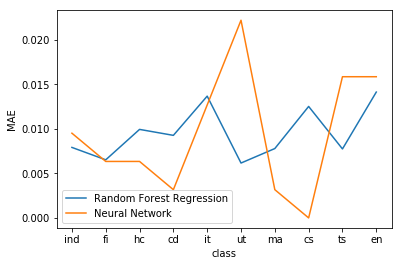

In [25]:
plt.plot(score_1)
plt.plot(score_2)
plt.legend(['Random Forest Regression','Neural Network'])
plt.xticks(range(10), abb_old)
plt.xlabel('class')
plt.ylabel('MAE')